# DEHP ALTERNATIVES ANALYSIS

## Get Modelable Properties

In [ ]:
import os, pandas as pd, sqlite3, seaborn as sns, matplotlib.pyplot as plt, sklearn.metrics, json
os.chdir('/home/tomlue/git/ai.biobricks/cvae')
from flask_cvae.app import Predictor

predictor : Predictor = Predictor()

def build_propdf():
    conn = sqlite3.connect('brick/cvae.sqlite')
    proptitle = pd.read_sql("SELECT property_token,title FROM property p", conn).groupby('property_token').first().reset_index()
    propdf = predictor._get_all_properties().groupby('property_token').first().reset_index()\
        .merge(proptitle, on='property_token', how='inner')

    # remove poor performing properties
    evaldf = pd.read_csv('data/metrics/multitask_metrics.csv')\
        .rename(columns={'assay':'property_token'})\
        .groupby('property_token').aggregate({'AUC':'median'})\
        .query('AUC > .7')\
        .reset_index()

    # remove irrelevant categories
    return propdf.merge(evaldf, on='property_token', how='inner')\
        .query('category != "kinetics (pharmacokinetics, toxicokinetics, adme, cmax, auc, etc)"')\
        .query('category != "chemical physical property"')\
        .rename(columns={'strength':'category_strength', 'title':'property_title','value':'known_value'})

propdf = build_propdf()
propdf[['source','property_title','category','reason']]

"{\"BioAssay Name\": \"qHTS for Inhibitors of human tyrosyl-DNA phosphodiesterase 1 (TDP1): qHTS in cells in presence of CPT\", \"Deposit Date\": 20130516.0, \"Gene IDs\": \"55775\", \"Modify Date\": 20130516.0, \"Outcome Type\": \"Confirmatory\", \"Project Category\": \"Molecular Libraries Probe Production Centers Network\", \"Protein Accessions\": \"AAI07878\", \"Source ID\": \"TDP1101\", \"Source Name\": \"National Center for Advancing Translational Sciences (NCATS)\", \"Substance Type\": \"small-molecule\", \"Taxonomy IDs\": \"9606\", \"aid\": 686979.0}"


## Get alternatives & join properties

In [75]:

dehp = "InChI=1S/C24H38O4/c1-5-9-13-19(7-3)17-27-23(25)21-15-11-12-16-22(21)24(26)28-18-20(8-4)14-10-6-2/h11-12,15-16,19-20H,5-10,13-14,17-18H2,1-4H3"
alternatives = {
    'Di(2-ethylhexyl) phthalate': dehp,
    'Diisononyl phthalate':                     "InChI=1S/C26H42O4/c1-21(2)15-9-5-7-13-19-29-25(27)23-17-11-12-18-24(23)26(28)30-20-14-8-6-10-16-22(3)4/h11-12,17-18,21-22H,5-10,13-16,19-20H2,1-4H3",
    'Diisodecyl phthalate':                     "InChI=1S/C28H46O4/c1-23(2)17-11-7-5-9-15-21-31-27(29)25-19-13-14-20-26(25)28(30)32-22-16-10-6-8-12-18-24(3)4/h13-14,19-20,23-24H,5-12,15-18,21-22H2,1-4H3",
    'Dioctyl terephthalate':                    "InChI=1S/C24H38O4/c1-3-5-7-9-11-13-19-27-23(25)21-15-17-22(18-16-21)24(26)28-20-14-12-10-8-6-4-2/h15-18H,3-14,19-20H2,1-2H3",
    'Acetyl tributyl citrate':                  "InChI=1S/C20H34O8/c1-5-8-11-25-17(22)14-20(28-16(4)21,19(24)27-13-10-7-3)15-18(23)26-12-9-6-2/h5-15H2,1-4H3",
    'Trioctyl trimellitate':                    "InChI=1S/C33H54O6/c1-7-13-16-25(10-4)22-37-31(34)28-19-20-29(32(35)38-23-26(11-5)17-14-8-2)30(21-28)33(36)39-24-27(12-6)18-15-9-3/h19-21,25-27H,7-18,22-24H2,1-6H3",
    'Diisononyl cyclohexane-1,2-dicarboxylate': "InChI=1S/C26H48O4/c1-21(2)15-9-5-7-13-19-29-25(27)23-17-11-12-18-24(23)26(28)30-20-14-8-6-10-16-22(3)4/h21-24H,5-20H2,1-4H3",
    'Butyryl trihexyl citrate':                 "InChI=1S/C28H50O8/c1-5-9-12-15-19-33-25(30)22-28(36-24(29)18-8-4,27(32)35-21-17-14-11-7-3)23-26(31)34-20-16-13-10-6-2/h5-23H2,1-4H3",
    'Di(2-ethylhexyl) terephthalate':           "InChI=1S/C24H38O4/c1-5-9-11-19(7-3)17-27-23(25)21-13-15-22(16-14-21)24(26)28-18-20(8-4)12-10-6-2/h13-16,19-20H,5-12,17-18H2,1-4H3",
}

# make alternatives df `altdf` and generate thousands of predictions
altdf = pd.DataFrame(alternatives.items(), columns=['name','inchi'])
altdf = altdf.assign(key=1).merge(propdf.assign(key=1), on='key').drop('key', axis=1)
altdf['prediction'] = altdf.progress_apply(lambda x: predictor.cached_predict_property(x['inchi'], x['property_token']), axis=1)

# get the known values from our databases
known_dfs = []
for inchi in altdf['inchi'].unique():
    df = pd.DataFrame(predictor._get_known_properties(inchi))[['inchi','property_token','value']]
    known_dfs.append(df)
knowndf = pd.concat(known_dfs)

# put alternatives, predictions, and known values together
altdf = altdf.merge(knowndf, on=['inchi','property_token'], how='left').drop_duplicates()
altdf['value'] = altdf['value'].fillna('unknown')

# show it to us
altdf[['name','category','category_strength','property_title','value','prediction']]


100%|██████████| 12321/12321 [00:00<00:00, 59706.10it/s]


,name,category,category_strength,property_title,value,prediction
0,Di(2-ethylhexyl) phthalate,genotoxicity,8.0,[inhibition of human tyrosyl-dna phosphodieste...,negative,0.587500
9,Di(2-ethylhexyl) phthalate,genotoxicity,7.0,assay for inhibitors of human tyrosyl-dna phos...,negative,0.795038
18,Di(2-ethylhexyl) phthalate,neurotoxicity,8.0,mlpcn alpha-synuclein 5'utr screening for smal...,unknown,0.077243
19,Di(2-ethylhexyl) phthalate,genotoxicity,7.0,assay for inhibitors of histone lysine methylt...,negative,0.810357
23,Di(2-ethylhexyl) phthalate,neurotoxicity,7.0,small molecule inhibitors assay for shiga toxi...,unknown,0.117055
...,...,...,...,...,...,...
18133,Di(2-ethylhexyl) terephthalate,endocrine disruption,3.0,ledgf/p75-integrase multimerization activator ...,unknown,0.168838
18134,Di(2-ethylhexyl) terephthalate,immunotoxicity,8.0,[cell-based high throughput cytotoxicity assay...,unknown,0.084121
18135,Di(2-ethylhexyl) terephthalate,immunotoxicity,8.0,cho cell-based toxicity assay for tlr9-myd88 b...,unknown,0.060355
18136,Di(2-ethylhexyl) terephthalate,hepatotoxicity,8.0,high throughput assay for hnf4 dimerization in...,unknown,0.082493


## What is model accuracy?

In [94]:
def compute_metrics(g):
    nprops = g['property_token'].nunique()
    numtrue = g['value'].sum()
    numfalse = len(g) - numtrue
    acc = sklearn.metrics.accuracy_score(g['value'], g['prediction'] > 0.5)
    return pd.Series({'accuracy': acc, 'numprops': nprops, 'numtrue': numtrue, 'numfalse': numfalse, 'numeval': len(g)})

# Group by 'inchi' and apply the metrics function
accdf = altdf.query('value in ["positive","negative"]').assign(value = altdf['value'] == 'positive')
accdf = accdf.query('category_strength > 8.0')
resdf = accdf.groupby(['category']).apply(compute_metrics)\
    .reset_index().sort_values('accuracy', ascending=False)

resdf

,category,accuracy,numprops,numtrue,numfalse,numeval
7,flammability,1.000000,2.0,0.0,12.0,12.0
12,neurotoxicity,1.000000,5.0,0.0,5.0,5.0
14,skin irritation,1.000000,2.0,0.0,12.0,12.0
1,acute oral toxicity,0.933333,4.0,1.0,14.0,15.0
0,acute inhalation toxicity,0.916667,2.0,0.0,12.0,12.0
3,carcinogenicity,0.907216,63.0,9.0,88.0,97.0
2,aquatic toxicity,0.866667,5.0,2.0,13.0,15.0
13,reproductive toxicity,0.857143,3.0,3.0,11.0,14.0
11,nephrotoxicity,0.833333,6.0,1.0,5.0,6.0
4,chronic toxicity,0.800000,4.0,3.0,7.0,10.0


## Which alts are most active?

In [84]:
# start by creating analysis dataframe `adf` with `likely_active` definition
relevant_hazards = ['reproductive toxicity','endocrine disruption','mutagenicity','developmental toxicity','genotoxicity']
adf = altdf\
    .assign(likely_active = altdf['prediction'] > 0.1)\
    .query(f'category in {relevant_hazards}')\
    .query(f'category_strength > 8.0')\
    .rename(columns={'title':'property_title','value':'known_value'})\
    [['name','property_title','category','known_value','prediction','likely_active']]\
    .drop_duplicates()
adf[['name','property_title','category','prediction','likely_active']]

,name,property_title,category,prediction,likely_active
148,Di(2-ethylhexyl) phthalate,high throughput screening for dna re-replicati...,genotoxicity,0.853706,True
182,Di(2-ethylhexyl) phthalate,ccris mutagenicity assay study,mutagenicity,0.152140,True
183,Di(2-ethylhexyl) phthalate,ccris mutagenicity assay study,mutagenicity,0.152140,True
200,Di(2-ethylhexyl) phthalate,assay for aromatase inhibition impact on viabi...,endocrine disruption,0.262963,True
201,Di(2-ethylhexyl) phthalate,estrogen receptor alpha antagonist assay (chap...,endocrine disruption,0.117753,True
...,...,...,...,...,...
17961,Di(2-ethylhexyl) terephthalate,estrogen receptor binding assays for chemical ...,endocrine disruption,0.202475,True
17962,Di(2-ethylhexyl) terephthalate,dsstox salmonella mutagenicity assay,mutagenicity,0.166662,True
17970,Di(2-ethylhexyl) terephthalate,[evaluation of antagonists of the thyroid stim...,endocrine disruption,0.602996,True
18038,Di(2-ethylhexyl) terephthalate,validation of inhibitors of the vitamin d rece...,endocrine disruption,0.081820,False


### Overall Hazard 

In [86]:
# OVERALL ACTIVITY
# we count which alts have the most likely_hazards
# ATBC is our overall least 'active' by a wide margin
# DEHP is 4th, and significantly worse than ATBC
# Dioctyl terephthalate is our overall most 'active'
count_activities = lambda x: pd.Series({'likely_activities': x['likely_active'].sum()})
adf.groupby('name').apply(count_activities).sort_values('likely_activities').reset_index()

,name,likely_activities
0,Acetyl tributyl citrate,74
1,Di(2-ethylhexyl) terephthalate,93
2,Diisononyl phthalate,118
3,Di(2-ethylhexyl) phthalate,121
4,"Diisononyl cyclohexane-1,2-dicarboxylate",134
5,Diisodecyl phthalate,146
6,Trioctyl trimellitate,150
7,Butyryl trihexyl citrate,157
8,Dioctyl terephthalate,157


### Endocrine Disruption

In [87]:
# ENDOCRINE DISRUPTION
# which alts have the most endocrine likely hazards
# ATBC least active
# Dioctyl terephthalate worst in endocrine as well
adf.query('category == "endocrine disruption"')\
    .groupby(['name']).apply(count_activities).sort_values('likely_activities').reset_index()
    

,name,likely_activities
0,Acetyl tributyl citrate,55
1,Di(2-ethylhexyl) terephthalate,78
2,Diisononyl phthalate,100
3,Di(2-ethylhexyl) phthalate,102
4,"Diisononyl cyclohexane-1,2-dicarboxylate",114
5,Diisodecyl phthalate,125
6,Trioctyl trimellitate,129
7,Butyryl trihexyl citrate,136
8,Dioctyl terephthalate,136


## Which properties have the most positives?

In [93]:
predsum = lambda x: pd.Series({'percent_positive': (x['prediction'] > 0.5).sum() / len(alternatives)})

pprops = altdf[['source', 'property_title', 'category', 'category_strength', 'name', 'prediction']]\
    .query('category_strength > 8.0')\
    .drop_duplicates()\
    .groupby(['source', 'property_title', 'category']).apply(predsum)\
    .sort_values('prediction_sum', ascending=False)\
    .reset_index()

# pprops.query('category == "developmental toxicity"')
pprops.query('category == "endocrine disruption"')

,source,property_title,category,prediction_sum
20,pubchem,[evaluation of antagonists of the thyroid stim...,endocrine disruption,1.000000
22,toxcast,erβ antagonist assay ratio in tox21,endocrine disruption,0.888889
23,bindingdb,assay for androgen receptor toxicity evaluation,endocrine disruption,0.888889
26,pubchem,insulin secretion assay for small-molecule act...,endocrine disruption,0.888889
35,toxcast,estrogen receptor activity assay,endocrine disruption,0.888889
...,...,...,...,...
371,toxcast,assay for agonistic activity on bla receptors ...,endocrine disruption,0.000000
372,toxcast,antagonistic effects on cell viability assay i...,endocrine disruption,0.000000
373,tox21,viability assay for er antagonists,endocrine disruption,0.000000
375,tox21,viability assay for active agonist chemicals t...,endocrine disruption,0.000000


# Visualize & Cluster Alternatives By Predicted Property

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, leaves_list

def plot_category(cat):
    pdf = altdf.query(f'category=="{cat}"').query('category_strength > 9')[['property_title','name','prediction']].drop_duplicates()
    pdf['property_title'] = pdf['property_title'].map(lambda x: x[:50] if len(x) > 25 else x)
    heatmap_data = pdf.pivot_table(values='prediction', columns='name', index='property_title', fill_value=0)

    # Compute the cosine distance and perform hierarchical clustering
    row_dist = pdist(heatmap_data, metric='cosine')
    col_dist = pdist(heatmap_data.T, metric='cosine')

    row_linkage = linkage(row_dist, method='average')
    col_linkage = linkage(col_dist, method='average')

    row_order = leaves_list(row_linkage)
    col_order = leaves_list(col_linkage)

    # Reorder the data
    heatmap_data = heatmap_data.iloc[row_order, col_order]

    # Identify the column to highlight
    highlight_col = 'Di(2-ethylhexyl) phthalate'

    # Plot the heatmap
    plt.figure(figsize=(12, 12), facecolor='black')
    cmap = sns.diverging_palette(250, 10, s=75, l=40, n=3, center="dark", as_cmap=True)  # Adjusted palette to go from dark to red
    ax = sns.heatmap(heatmap_data, cmap=cmap, annot=False, square=True, fmt=".2f",
                    linewidths=0.5, linecolor='black', cbar_kws={"shrink": .8})

        # Highlight the specific column with a semi-transparent gold overlay
    if highlight_col in heatmap_data.columns:
        highlight_index = list(heatmap_data.columns).index(highlight_col)
        for _, spine in ax.spines.items():
            spine.set_visible(True)
            spine.set_edgecolor('white')
        for tick_label in ax.get_xticklabels():
            if tick_label.get_text() == highlight_col:
                tick_label.set_color('yellow')
                tick_label.set_fontweight('bold')
        
        # Add a rectangle to highlight the column
        for y in range(len(heatmap_data)):
            ax.add_patch(Rectangle((highlight_index, y), 1, 1, fill=False, edgecolor='white'))


    # Set the tick labels color for row and column names
    ax.tick_params(axis='x', colors='white', rotation=45)
    ax.tick_params(axis='y', colors='white')

    # Set the axes background color to black
    ax.set_facecolor('black')

    # Adjust the x-axis label position
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')

    # Improve the appearance of the colorbar
    cbar = ax.collections[0].colorbar
    cbar.set_label('Active Probability', color='white')
    cbar.ax.yaxis.set_tick_params(color='white')
    cbar.ax.yaxis.set_ticklabels([f'{x:.2f}' for x in cbar.get_ticks()], color='white')

    # Show the plot with black background
    plt.show()



/tmp/ipykernel_483951/4243010028.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.yaxis.set_ticklabels([f'{x:.2f}' for x in cbar.get_ticks()], color='white')


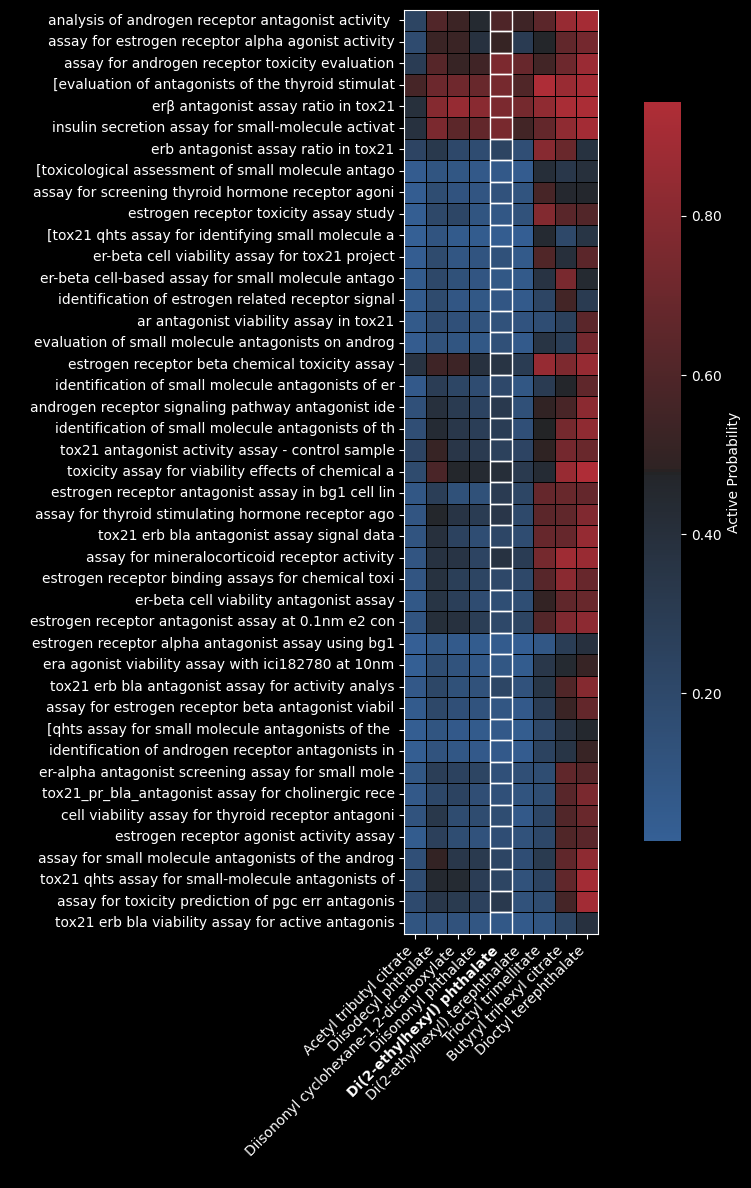

In [70]:
plot_category('endocrine disruption')